In [1]:
import pandas as pd
import os

# 设置路径
base_path = "../before modeling"
auc_file = os.path.join(base_path, "logistic_regression_auc_scores.csv")
train_dir = "../train"
train_files = [
    "E-MTAB-316.csv",
    "GSE5900.csv",
    "GSE6477.csv",
    "GSE13591.csv"
]

# 读取 AUC 文件并筛选 AUC > 0.6 的基因名
auc_df = pd.read_csv(auc_file)
selected_genes = auc_df[auc_df['AUC'] > 0.6]['Gene'].tolist()

# 初始化合并数据
combined_df = pd.DataFrame()

# 依次读取训练集并提取所需基因
for file in train_files:
    path = os.path.join(train_dir, file)
    df = pd.read_csv(path)

    # 找出当前数据集中确实包含的基因
    genes_in_file = [gene for gene in selected_genes if gene in df.columns]

    # 提取 SampleID、source 和选中基因
    selected_cols = ['SampleID', 'Dataset'] + genes_in_file
    filtered_df = df[selected_cols]

    # 合并
    combined_df = pd.concat([combined_df, filtered_df], axis=0)

# 保存为 CSV 文件
combined_df.to_csv("638.csv", index=False)
print("✅ 筛选完成，已保存为 638.csv")

✅ 筛选完成，已保存为 638.csv


In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
)
import joblib

# === 1. 读取特征数据 ===
X = pd.read_csv("638.csv")  # 包含 SampleID、Dataset、基因表达量

# === 2. 构建标签 y：从 metadata 文件中提取 ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-316_metadata.csv",
    "GSE5900_metadata.csv",
    "GSE6477_metadata.csv",
    "GSE13591_metadata.csv"
]

metadata_all = pd.DataFrame()
for file in metadata_files:
    df = pd.read_csv(os.path.join(metadata_dir, file))
    df = df[['SampleID', 'label']]
    df = df[df['label'].notna()]
    metadata_all = pd.concat([metadata_all, df], axis=0)

# 映射标签 y
label_df = metadata_all.set_index("SampleID")
y = X["SampleID"].map(label_df["label"])

# === 3. 去除无标签样本，构建模型输入 X_model ===
valid_idx = y.notna()
y = y[valid_idx].astype(int)

# 丢掉非特征列，只保留表达量
X_model = X.drop(columns=["SampleID", "Dataset"]).loc[valid_idx]
X_model = X_model.select_dtypes(include=[np.number])

# === 4. 建模流程：ElasticNet + 标准化 + GridSearchCV ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000))
])

param_grid = {
    "clf__C": np.logspace(-4, 3, 12),
    "clf__l1_ratio": np.linspace(0.0, 1.0, 21)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 拟合 + 最佳模型
grid.fit(X_model, y)
best_model = grid.best_estimator_

# === 5. 5-Fold 验证评估 ===
scores = {
    "ROC_AUC": [],
    "ACCURACY": [],
    "F1": [],
    "PRECISION": [],
    "RECALL": []
}

for train_idx, test_idx in cv.split(X_model, y):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    scores["ROC_AUC"].append(roc_auc_score(y_test, y_proba))
    scores["ACCURACY"].append(accuracy_score(y_test, y_pred))
    scores["F1"].append(f1_score(y_test, y_pred))
    scores["PRECISION"].append(precision_score(y_test, y_pred))
    scores["RECALL"].append(recall_score(y_test, y_pred))

# === 6. 输出评估结果 ===
print("\n✅ ElasticNetCV 5-Fold 平均评估结果：")
for metric, values in scores.items():
    print(f"{metric}: {np.mean(values):.4f}")

# === 7. 保存模型 ===
joblib.dump(best_model, "elasticnet_model.pkl")
print("\n✅ 最佳模型已保存为 elasticnet_model.pkl")

Fitting 5 folds for each of 252 candidates, totalling 1260 fits

✅ ElasticNetCV 5-Fold 平均评估结果：
ROC_AUC: 0.7187
ACCURACY: 0.6845
F1: 0.7413
PRECISION: 0.6820
RECALL: 0.8135

✅ 最佳模型已保存为 elasticnet_model.pkl


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# === 1. 读取表达矩阵（仅保留 AUC > 0.6 的基因）===
data_path = "638.csv"  # 请按你的路径修改
X = pd.read_csv(data_path)

# === 2. 读取 metadata 并整合样本标签 ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-316_metadata.csv",
    "GSE5900_metadata.csv",
    "GSE6477_metadata.csv",
    "GSE13591_metadata.csv"
]

metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, file))
    for file in metadata_files
], ignore_index=True)

# 仅保留 SampleID 和 label 两列，并排除 label 缺失
metadata_all = metadata_all[["SampleID", "label"]]
metadata_all = metadata_all[metadata_all["label"].notna()]

# === 3. 构建 y ===
label_df = metadata_all.set_index("SampleID")
y = X["SampleID"].map(label_df["label"])

# === 4. 丢弃无标签的样本 ===
valid_idx = y.notna()
y = y[valid_idx].astype(int)
X_model = X.loc[valid_idx].drop(columns=["SampleID", "Dataset"], errors="ignore")

# === 5. 构建 Pipeline：标准化 + 随机森林 ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

# === 6. 设置调参网格 ===
param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10]
}

# === 7. 进行网格搜索（5-Fold）===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_model, y)
best_model = grid.best_estimator_

# === 8. 手动 5-Fold 验证评分 ===
scores = {
    "ROC_AUC": [],
    "ACCURACY": [],
    "F1": [],
    "PRECISION": [],
    "RECALL": []
}

for train_idx, test_idx in cv.split(X_model, y):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    scores["ROC_AUC"].append(roc_auc_score(y_test, y_proba))
    scores["ACCURACY"].append(accuracy_score(y_test, y_pred))
    scores["F1"].append(f1_score(y_test, y_pred))
    scores["PRECISION"].append(precision_score(y_test, y_pred))
    scores["RECALL"].append(recall_score(y_test, y_pred))

# === 9. 输出评估结果 ===
print("\n✅ Random Forest 5-Fold 平均评估结果：")
for metric, values in scores.items():
    print(f"{metric}: {np.mean(values):.4f}")

# === 10. 保存模型 ===
joblib.dump(best_model, "random_forest_model.pkl")
print("\n✅ 模型已保存为 random_forest_model.pkl")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Random Forest 5-Fold 平均评估结果：
ROC_AUC: 0.8442
ACCURACY: 0.7352
F1: 0.7896
PRECISION: 0.7089
RECALL: 0.8923

✅ 模型已保存为 random_forest_model.pkl


In [3]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# === 1. 读取表达矩阵（仅保留 AUC > 0.6 的基因）===
data_path = "638.csv"  # 请按你的路径修改
X = pd.read_csv(data_path)

# === 2. 读取 metadata 并整合样本标签 ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-316_metadata.csv",
    "GSE5900_metadata.csv",
    "GSE6477_metadata.csv",
    "GSE13591_metadata.csv"
]

metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, file))
    for file in metadata_files
], ignore_index=True)

# 仅保留 SampleID 和 label 两列，并排除 label 缺失
metadata_all = metadata_all[["SampleID", "label"]]
metadata_all = metadata_all[metadata_all["label"].notna()]

# === 3. 构建 y ===
label_df = metadata_all.set_index("SampleID")
y = X["SampleID"].map(label_df["label"])

# === 4. 丢弃无标签的样本 ===
valid_idx = y.notna()
y = y[valid_idx].astype(int)
X_model = X.loc[valid_idx].drop(columns=["SampleID", "Dataset"], errors="ignore")

# === 5. 构建 Pipeline：标准化 + XGBoost ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

# === 6. 设置调参网格 ===
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 1.0]
}

# === 7. 网格搜索（5-Fold）===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_model, y)
best_model = grid.best_estimator_

# === 8. 手动 5-Fold 验证评分 ===
scores = {
    "ROC_AUC": [],
    "ACCURACY": [],
    "F1": [],
    "PRECISION": [],
    "RECALL": []
}

for train_idx, test_idx in cv.split(X_model, y):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    scores["ROC_AUC"].append(roc_auc_score(y_test, y_proba))
    scores["ACCURACY"].append(accuracy_score(y_test, y_pred))
    scores["F1"].append(f1_score(y_test, y_pred))
    scores["PRECISION"].append(precision_score(y_test, y_pred))
    scores["RECALL"].append(recall_score(y_test, y_pred))

# === 9. 输出评估结果 ===
print("\n✅ XGBoost 5-Fold 平均评估结果：")
for metric, values in scores.items():
    print(f"{metric}: {np.mean(values):.4f}")

# === 10. 保存模型 ===
joblib.dump(best_model, "xgboost_model.pkl")
print("\n✅ 模型已保存为 xgboost_model.pkl")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:25:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:25:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:25:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:25:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:7


✅ XGBoost 5-Fold 平均评估结果：
ROC_AUC: 0.8802
ACCURACY: 0.8042
F1: 0.8326
PRECISION: 0.7961
RECALL: 0.8756

✅ 模型已保存为 xgboost_model.pkl


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# === 1. 读取表达数据 ===
data_path = "638.csv"  # 请根据实际路径修改
X = pd.read_csv(data_path)

# === 2. 读取标签 metadata ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-316_metadata.csv",
    "GSE5900_metadata.csv",
    "GSE6477_metadata.csv",
    "GSE13591_metadata.csv"
]

metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, file))
    for file in metadata_files
], ignore_index=True)

# 仅保留必要列并去除缺失
metadata_all = metadata_all[["SampleID", "label"]]
metadata_all = metadata_all[metadata_all["label"].notna()]

# === 3. 构建 y 标签向量 ===
label_df = metadata_all.set_index("SampleID")
y = X["SampleID"].map(label_df["label"])

# === 4. 过滤无标签样本 + 构建 X ===
valid_idx = y.notna()
y = y[valid_idx].astype(int)
X_model = X.loc[valid_idx].drop(columns=["SampleID", "Dataset"], errors="ignore")

# === 5. Pipeline：标准化 + SVM ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True))
])

# === 6. SVM 超参数搜索范围 ===
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__gamma": ["scale", 0.001, 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# === 7. 模型训练 ===
grid.fit(X_model, y)
best_model = grid.best_estimator_

# === 8. 5-Fold 验证评估 ===
scores = {
    "ROC_AUC": [],
    "ACCURACY": [],
    "F1": [],
    "PRECISION": [],
    "RECALL": []
}

for train_idx, test_idx in cv.split(X_model, y):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    scores["ROC_AUC"].append(roc_auc_score(y_test, y_proba))
    scores["ACCURACY"].append(accuracy_score(y_test, y_pred))
    scores["F1"].append(f1_score(y_test, y_pred))
    scores["PRECISION"].append(precision_score(y_test, y_pred))
    scores["RECALL"].append(recall_score(y_test, y_pred))

# === 9. 输出结果 ===
print("\n✅ SVM (RBF) 5-Fold 平均评估结果：")
for metric, values in scores.items():
    print(f"{metric}: {np.mean(values):.4f}")

# === 10. 保存模型 ===
joblib.dump(best_model, "svm_rbf_model.pkl")
print("\n✅ 模型已保存为 svm_rbf_model.pkl")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

✅ SVM (RBF) 5-Fold 平均评估结果：
ROC_AUC: 0.8136
ACCURACY: 0.7420
F1: 0.7894
PRECISION: 0.7228
RECALL: 0.8713

✅ 模型已保存为 svm_rbf_model.pkl


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer, accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score
)
import joblib
import os

# === 1. 读取表达数据 ===
data_path = "638.csv"
X = pd.read_csv(data_path)

# === 2. 读取标签 metadata ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-316_metadata.csv",
    "GSE5900_metadata.csv",
    "GSE6477_metadata.csv",
    "GSE13591_metadata.csv"
]

metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, file))
    for file in metadata_files
], ignore_index=True)

metadata_all = metadata_all[["SampleID", "label"]]
metadata_all = metadata_all[metadata_all["label"].notna()]

# === 3. 构建标签向量 y ===
label_df = metadata_all.set_index("SampleID")
y = X["SampleID"].map(label_df["label"])
valid_idx = y.notna()
y = y[valid_idx].astype(int)
X_model = X.loc[valid_idx].drop(columns=["SampleID", "Dataset"], errors="ignore")

# === 4. 构建 stacking 模型 ===
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]

final_estimator = LogisticRegressionCV(cv=5, max_iter=1000)

stacking = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=False
    ))
])

# === 5. 定义评分指标 ===
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 6. 交叉验证 ===
results = cross_validate(stacking, X_model, y, cv=cv, scoring=scoring, return_train_score=False)

# === 7. 输出平均结果 ===
print("\n✅ Stacking Classifier 5-Fold 评估结果:")
for metric in scoring.keys():
    score_values = results[f'test_{metric}']
    print(f"{metric.upper()}: {np.mean(score_values):.4f}")

# === 8. 训练全量模型并保存 ===
stacking.fit(X_model, y)
joblib.dump(stacking, "stacking_model.pkl")
print("\n✅ 模型已保存为 stacking_model.pkl")

/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183:


✅ Stacking Classifier 5-Fold 评估结果:
ROC_AUC: 0.8561
ACCURACY: 0.7421
F1: 0.7899
PRECISION: 0.7300
RECALL: 0.8674


/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




✅ 模型已保存为 stacking_model.pkl


In [12]:
import os
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# === 1. 模型路径（确保文件存在） ===
model_paths = {
    "ElasticNet": "elasticnet_model.pkl",
    "RandomForest": "random_forest_model.pkl",
    "XGBoost": "xgboost_model.pkl",
    "SVM": "svm_rbf_model.pkl",
    "Stacking": "stacking_model.pkl"
}

# === 2. 读取测试集数据 ===
test_dir = "../test"
test_files = [f for f in os.listdir(test_dir) if f.endswith(".csv")]
test_dfs = [pd.read_csv(os.path.join(test_dir, f)) for f in test_files]
test_df = pd.concat(test_dfs, axis=0).reset_index(drop=True)

# === 3. 加载测试集 label ===
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-317_metadata.csv",
    "GSE2113_metadata.csv",
    "GSE235356_metadata.csv",
]
metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, f))[["SampleID", "label"]] for f in metadata_files
])
metadata_all = metadata_all.dropna(subset=["label"])
metadata_all["label"] = metadata_all["label"].astype(int)

# === 4. 构建测试集 X 和 y ===
label_df = metadata_all.set_index("SampleID")
y_test = test_df["SampleID"].map(label_df["label"])
valid_idx = y_test.notna()
X_test = test_df.loc[valid_idx].drop(columns=["SampleID"])
y_test = y_test[valid_idx].astype(int)

# === 5. 模型测试函数 ===
def evaluate_model(name, model, X, y):
    if hasattr(model, "feature_names_in_"):
        X = X.loc[:, model.feature_names_in_]
    else:
        try:
            scaler = model.named_steps["scaler"]
            X = X.loc[:, scaler.feature_names_in_]
        except:
            pass
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    return {
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_prob) if y_prob is not None else "N/A"
    }

# === 6. 批量评估模型 ===
results = []
for name, path in model_paths.items():
    model = joblib.load(path)
    score = evaluate_model(name, model, X_test, y_test)
    results.append(score)

# === 7. 输出结果 ===
results_df = pd.DataFrame(results)
print(results_df)
# === 8. 输出测试样本数量 ===
print(f"\n📊 有效测试样本数量：{X_test.shape[0]}")

          Model  Accuracy        F1  Precision    Recall   ROC AUC
0    ElasticNet  0.623077  0.726257   0.716912  0.735849  0.489389
1  RandomForest  0.669231  0.762431   0.744604  0.781132  0.692679
2       XGBoost  0.682051  0.768657   0.760148  0.777358  0.684830
3           SVM  0.648718  0.726547   0.771186  0.686792  0.674506
4      Stacking  0.710256  0.802102   0.748366  0.864151  0.702611

📊 有效测试样本数量：390


In [9]:
print("测试集样本（前5个）：", test_df["SampleID"].unique()[:5])
print("标签集样本（前5个）：", metadata_df["SampleID"].unique()[:5])
print("测试集样本总数：", test_df["SampleID"].nunique())
print("标签集样本总数：", metadata_df["SampleID"].nunique())
print("交集数量：", len(set(test_df["SampleID"]) & set(metadata_df["SampleID"])))

测试集样本（前5个）： ['S256' 'S264' 'S285' 'S351' 'S303']
标签集样本（前5个）： ['E4038' 'S1055' 'S1047' 'E4050' 'S256']
测试集样本总数： 249
标签集样本总数： 249
交集数量： 249


In [11]:
import pandas as pd
import os

# === 设置路径 ===
test_dir = "../test"
metadata_dir = "../metadata"
metadata_files = [
    "E-MTAB-317_metadata.csv",
    "GSE2113_metadata.csv",
    "GSE235356_metadata.csv",
]

# === 读取并合并测试数据 ===
test_files = [f for f in os.listdir(test_dir) if f.endswith(".csv")]
test_dfs = [pd.read_csv(os.path.join(test_dir, f)) for f in test_files]
test_df = pd.concat(test_dfs, axis=0).reset_index(drop=True)

# === 加载并合并 metadata，提取标签 ===
metadata_all = pd.concat([
    pd.read_csv(os.path.join(metadata_dir, f))[["SampleID", "label"]]
    for f in metadata_files
])
metadata_all = metadata_all.dropna(subset=["label"])
metadata_all["label"] = metadata_all["label"].astype(int)
label_df = metadata_all.set_index("SampleID")

# === 匹配标签并筛选有效样本 ===
y_test = test_df["SampleID"].map(label_df["label"])
valid_idx = y_test.notna()
X_test = test_df.loc[valid_idx].drop(columns=["SampleID"])
y_test = y_test[valid_idx].astype(int)

# === 检查匹配情况 ===
all_test_ids = set(test_df["SampleID"])
all_meta_ids = set(metadata_all["SampleID"])
matched_ids = all_test_ids & all_meta_ids
unmatched_ids = all_test_ids - all_meta_ids

print("✅ 成功匹配的样本数：", len(matched_ids))
print("❌ 无法匹配标签的样本数：", len(unmatched_ids))
print("🧪 最终有效测试样本数量（可用于模型评估）：", X_test.shape[0])

# === 可选：查看未匹配样本（前5个） ===
if len(unmatched_ids) > 0:
    print("🔍 示例未匹配样本（前5个）：", list(unmatched_ids)[:5])

# === 样本详情 ===
print("\n📋 有效测试样本详情（前10个）：")
print(y_test.reset_index().rename(columns={"index": "SampleID"}).head(10))

✅ 成功匹配的样本数： 390
❌ 无法匹配标签的样本数： 269
🧪 最终有效测试样本数量（可用于模型评估）： 390
🔍 示例未匹配样本（前5个）： ['GSM7501057', 'GSM7501034', 'GSM7501214', 'GSM7501168', 'GSM7501007']

📋 有效测试样本详情（前10个）：
   SampleID  SampleID
0         0         0
1         1         0
2         2         0
3         3         0
4         4         0
5         5         0
6         6         0
7         7         0
8         8         0
9         9         0


🔄 处理 GSE2113.csv
🔄 处理 GSE235356.csv
🔄 处理 E-MTAB-317.csv


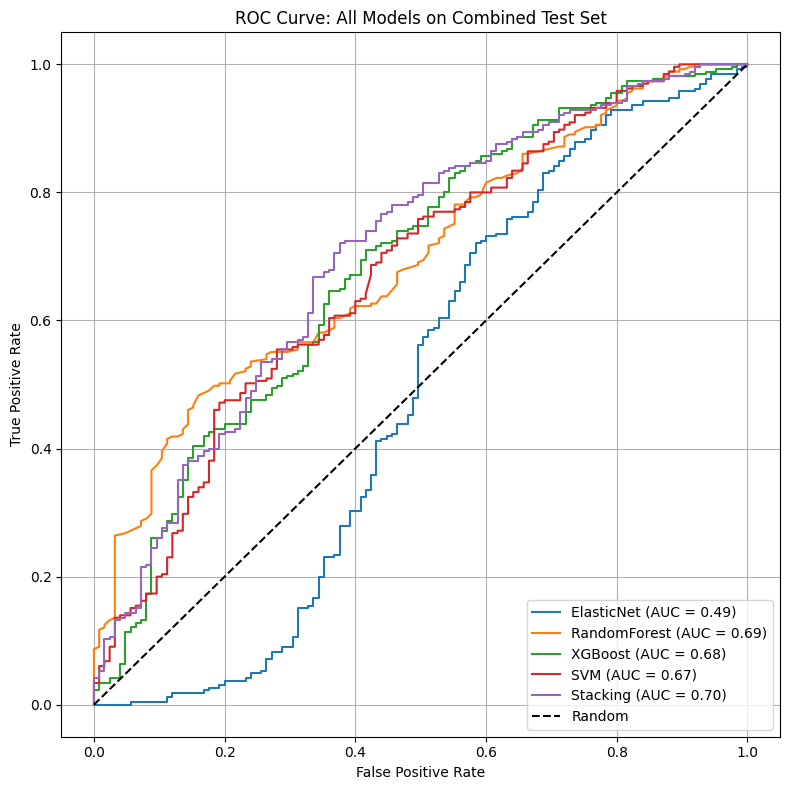

In [7]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler

# === 模型路径 ===
model_paths = {
    "ElasticNet": "elasticnet_model.pkl",
    "RandomForest": "random_forest_model.pkl",
    "XGBoost": "xgboost_model.pkl",
    "SVM": "svm_rbf_model.pkl",
    "Stacking": "stacking_model.pkl"
}

# === 三个测试集及其 metadata 配对 ===
test_metadata_pairs = [
    ("GSE2113.csv", "GSE2113_metadata.csv"),
    ("GSE235356.csv", "GSE235356_metadata.csv"),
    ("E-MTAB-317.csv", "E-MTAB-317_metadata.csv")
]

# === 路径设置 ===
test_dir = "../test"
metadata_dir = "../metadata"

# === 训练时使用的基因特征列表 ===
train_gene_df = pd.read_csv("638.csv")
train_genes = [col for col in train_gene_df.columns if col != "SampleID" and not col.startswith("Dataset")]

# === 汇总整合所有测试数据和标签 ===
all_X = []
all_y = []

for test_file, meta_file in test_metadata_pairs:
    print(f"🔄 处理 {test_file}")

    # 加载测试数据
    test_df = pd.read_csv(os.path.join(test_dir, test_file))
    test_df["SampleID"] = test_df["SampleID"].astype(str).str.strip().str.upper()

    # 加载对应标签
    metadata_df = pd.read_csv(os.path.join(metadata_dir, meta_file))
    metadata_df = metadata_df.dropna(subset=["label"])
    metadata_df["SampleID"] = metadata_df["SampleID"].astype(str).str.strip().str.upper()

    # 标签匹配
    sample_to_label = metadata_df.set_index("SampleID")["label"].to_dict()
    y = test_df["SampleID"].map(sample_to_label)
    matched_indices = y.dropna().index

    if len(matched_indices) == 0:
        print(f"⚠️ 跳过 {test_file}（无匹配标签）")
        continue

    y = y.loc[matched_indices].astype(int)
    X = test_df.loc[matched_indices]

    # 检查缺失特征
    missing = [g for g in train_genes if g not in X.columns]
    if missing:
        print(f"⚠️ 跳过 {test_file}（缺失特征列：{missing}）")
        continue

    X = X[train_genes]
    all_X.append(X)
    all_y.append(y)

# === 合并所有子集为整合测试集 ===
if not all_X:
    raise ValueError("❌ 没有任何测试集可以用于评估，请检查样本与标签是否匹配。")

X_test = pd.concat(all_X, axis=0).reset_index(drop=True)
y_test = pd.concat(all_y, axis=0).reset_index(drop=True)
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# === 绘制 ROC 曲线 ===
plt.figure(figsize=(8, 8))
for name, path in model_paths.items():
    model = joblib.load(path)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        scores = model.decision_function(X_test)
        y_prob = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: All Models on Combined Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import os
import pandas as pd

# 路径设置
test_dir = "../test"
metadata_dir = "../metadata"

test_metadata_pairs = [
    ("GSE2113.csv", "GSE2113_metadata.csv"),
    ("GSE235356.csv", "GSE235356_metadata.csv"),
    ("E-MTAB-317.csv", "E-MTAB-317_metadata.csv")
]

# 训练使用的基因特征
train_gene_df = pd.read_csv("AUC0.6.csv")
train_genes = [col for col in train_gene_df.columns if col != "SampleID" and not col.startswith("Dataset")]

# 构建测试集
all_X = []
all_y = []

for test_file, meta_file in test_metadata_pairs:
    test_df = pd.read_csv(os.path.join(test_dir, test_file))
    test_df["SampleID"] = test_df["SampleID"].astype(str).str.strip().str.upper()

    metadata_df = pd.read_csv(os.path.join(metadata_dir, meta_file))
    metadata_df = metadata_df.dropna(subset=["label"])
    metadata_df["SampleID"] = metadata_df["SampleID"].astype(str).str.strip().str.upper()

    sample_to_label = metadata_df.set_index("SampleID")["label"].to_dict()
    y = test_df["SampleID"].map(sample_to_label)
    matched_indices = y.dropna().index

    if len(matched_indices) == 0:
        continue

    y = y.loc[matched_indices].astype(int)
    X = test_df.loc[matched_indices]

    # 保证特征一致
    missing = [g for g in train_genes if g not in X.columns]
    if missing:
        continue

    X = X[train_genes]
    all_X.append(X)
    all_y.append(y)

X_test = pd.concat(all_X, axis=0).reset_index(drop=True)
y_test = pd.concat(all_y, axis=0).reset_index(drop=True)

# 二分类标签化
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

In [5]:
import joblib
from sklearn.metrics import roc_auc_score

model = joblib.load("elasticnet_model.pkl")
y_prob = model.predict_proba(X_test)[:, 1]
y_prob_inverted = 1 - y_prob

print("原始 AUC:", roc_auc_score(y_test_bin, y_prob))
print("反转后 AUC:", roc_auc_score(y_test_bin, y_prob_inverted))

原始 AUC: 0.4859471698113207
反转后 AUC: 0.5140528301886793


In [60]:
import pandas as pd

# 自行填写数据集路径
file_path = '../test/merged_test.csv'

# 读取 CSV 文件（自动判断是否需要设 index）
df = pd.read_csv(file_path)

# 输出行数和列数
print(f"文件: {file_path}")
print(f"总行数（样本数）: {df.shape[0]}")
print(f"总列数（特征数）: {df.shape[1]}")

# 输出前5行前5列
print("\n前5行 × 前5列数据预览：")
print(df.iloc[:5, :5])

文件: ../test/merged_test.csv
总行数（样本数）: 659
总列数（特征数）: 12922

前5行 × 前5列数据预览：
     SampleID    Dataset      A1CF       A2M    A4GALT
0  GSM7500908  GSE235356 -0.223019  0.106149  0.011009
1  GSM7500909  GSE235356  1.624882  0.027545  0.613559
2  GSM7500910  GSE235356 -0.381968  0.165010  0.421900
3  GSM7500911  GSE235356 -0.031503 -0.770207  0.391359
4  GSM7500912  GSE235356  0.886966 -0.014223  0.519464
